In [ ]:
# https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/seminars/sem21-gp.pdf

##### Факты о нормальном (Гауссовском) распределении

Плотность задается вектором средних и матрицей ковариаций:
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720144541091-486941526.png">

Моменты
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720151819591-969038635.png">
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720151927716-615809176.png">
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720151916747-940448986.png">

Маргинальное распределение
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720195012638-1045172585.png">

тоже является Гауссовским с параметрами
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720195047169-429403054.png">

Условное распределение тоже является Гауссовским с параметрами
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720194733044-1648101382.png">

Формула Байеса
<img src="http://images2015.cnblogs.com/blog/823855/201607/823855-20160720195546154-325591174.png">

см. http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html

# Regression

<img src="http://slideplayer.com/4861373/15/images/21/Gaussian+processes+for+regression%283%29.jpg" width=600>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
eps = 1e-8

def logdet(X):
    sign, logdet = np.linalg.slogdet(X)
    return logdet

def rbf_covariance(kernel_params, x, xp=None):
    _xp = x if xp is None else xp
    output_scale = (kernel_params[0])**2 #parametrization
    lengthscales = (kernel_params[1:])**2 #parametrizationS
    diffs = np.expand_dims(x /lengthscales, 1) - np.expand_dims(_xp/lengthscales, 0)
    rbf = output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))
    return (rbf + eps * np.eye(x.shape[0])) if xp is None else rbf # for numerical stability

In [3]:
np.random.seed(4)

X = np.sort(7 * np.random.rand(15, 1), axis=0)
y = np.sin(X).ravel()
y = y + 0.2*np.random.randn(len(y))

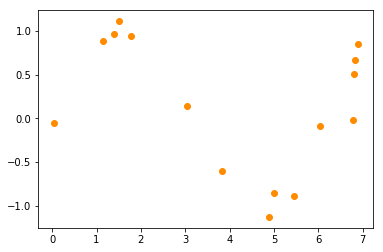

In [4]:
plt.scatter(X, y, color='darkorange', label='data')
plt.show()

Рассмотрим [Гауссовский](https://ru.wikipedia.org/wiki/%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81) [процесс](https://ru.wikipedia.org/wiki/%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81) (ГП) с нулевой функцией среднего и некоторой ковариационной функцией $k(\cdot, \cdot)$, индексированный векторами $\mathbf{x} \in \mathbb{R}^d$. Обозначим $f \sim \mathcal{GP}(0, k(\cdot, \cdot))$ некоторую реализацию ГП. Тогда для любого набора $\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N$ случайный вектор $\mathbf{f} = (f(\mathbf{x}_1), f(\mathbf{x}_2), ..., f(\mathbf{x}_N))^T$ имеет многомерное нормальное распределение: $\mathbf{f} \sim N(\mathbf{0}, \mathbf{K})$, где $\mathbf{K}_{ij} = k(\mathbf{x}_i,\mathbf{x}_j)$.

Пусть распределение независимой (прогнозируемой) переменной задано следующей плотностью $p(y|f(\mathbf{x}))$, где $f(\mathbf{x})$ -- значение реализации ГП в точке $\mathbf{x}$. Нужно на основе обучающей выбоки $\mathbf{y}$ предсказать значение вектора $\mathbf{y}_*$, соответствующего тестовой выборки.

Для этого рассмотрим совместное распределение значений реализации ГП для обучающей и тестовой выборки:
\begin{equation}
 p(\mathbf{f}, \mathbf{f}_{*}) = N \left(
\begin{bmatrix}
\mathbf{f} \\
\mathbf{f}_{*}
\end{bmatrix}
|
\begin{bmatrix}
\mathbf{0} \\
\mathbf{0}
\end{bmatrix}
,
 \begin{bmatrix}
  \mathbf{K} & \mathbf{K}_{*}^T  \\
  \mathbf{K}_{*} & \mathbf{K}_{**} 
 \end{bmatrix} 
 \right)
 \end{equation}
 
 Также, как обычно, мы предполагаем, что значения переменных $y_i$ независимы при фиксированной реализации $f$.
 Тогда полное совместное распределение будет факторизоваться следующим образом:
 
$$p(\mathbf{y},\mathbf{y}_*,\mathbf{f},\mathbf{f}_*) = p(\mathbf{y}_*|\mathbf{f}_*)p(\mathbf{y}|\mathbf{f}) p(\mathbf{f}_{*}, \mathbf{f})$$

Наша цель - получить распределение для прогноза: $p(\mathbf{y}_*|\mathbf{y})$. Применяя _sum rule и product rule_ (формула полной вероятности и формула условной вероятности) 
<img src="https://datastoriesweb.files.wordpress.com/2017/06/p1.png">
получим:

$$p(\mathbf{y},\mathbf{y}_*,\mathbf{f},\mathbf{f}_*) = p(\mathbf{y}_*|\mathbf{f}_*)p(\mathbf{y}|\mathbf{f}) p(\mathbf{f}_{*}, \mathbf{f}) = \{product\_rule\} = p(\mathbf{y}_*|\mathbf{f}_*)p(\mathbf{y}|\mathbf{f}) p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}) = \{product\_rule\} = p(\mathbf{y}_*|\mathbf{f}_*) p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}|\mathbf{y})p(\mathbf{y})$$

Разделим обе части на $p(\mathbf{y})$ (_product rule_):

$$p(\mathbf{y}_*,\mathbf{f},\mathbf{f}_*|\mathbf{y}) = p(\mathbf{y}_*|\mathbf{f}_*) p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}|\mathbf{y})$$

И проинтегрируем по $\mathbf{f}_*$ и $\mathbf{f}$ (_sum rule_):

$$p(\mathbf{y}_*|\mathbf{y}) = \int p(\mathbf{y}_*|\mathbf{f}_*) p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}|\mathbf{y}) d\mathbf{f}_{*} d\mathbf{f} = \int p(\mathbf{y}_*|\mathbf{f}_*) \left( \int p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}|\mathbf{y}) d\mathbf{f} \right) d\mathbf{f}_{*} = \int p(\mathbf{y}_*|\mathbf{f}_*) p(\mathbf{f}_{*}|\mathbf{y}) d\mathbf{f}_{*} = \mathbb{E}_{p(\mathbf{f}_{*}|\mathbf{y})}[p(\mathbf{y}_*|\mathbf{f}_*)]$$

Пользуясь свойствами Гауссовского распределения, находим:

$p(\mathbf{f}_{*}| \mathbf{f}) = N(\mathbf{f}_*|\mathbf{K}_*\mathbf{K}^{-1}\mathbf{f}, \mathbf{K}_{**} - \mathbf{K}_*\mathbf{K}^{-1}\mathbf{K}_*^T)$

$p(\mathbf{f}) = N(\mathbf{f}|\mathbf{0}, \mathbf{K})$

Запишем апостериорное распределение для общего случая, поскольку оно зависит от определения $p(y|f)$:

$p(\mathbf{f}|\mathbf{y}) = N(\mathbf{f}|\mathbf{\mu}, \mathbf{\Sigma})$

$p(\mathbf{f}_{*}|\mathbf{y}) = \int p(\mathbf{f}_{*}| \mathbf{f})p(\mathbf{f}|\mathbf{y}) d\mathbf{f} = N(\mathbf{f}_*|\mathbf{K}_*\mathbf{K}^{-1}\mathbf{\mu}, \mathbf{K}_{**} - \mathbf{K}_*\mathbf{K}^{-1}\mathbf{K}_*^T + \mathbf{K}_*\mathbf{K}^{-1}\mathbf{\Sigma} \mathbf{K}^{-1}\mathbf{K}_*^T)$


##### Пример:

$p(y|f) = N(y|f, \sigma^2)$

В этом случае $\mathbf{\Sigma} = (\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1}$ и $\mathbf{\mu} = \sigma^{-2}\mathbf{\Sigma} \mathbf{y} = \sigma^{-2}(\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{y} $.

$$ p(\mathbf{f}_{*}|\mathbf{y}) = N(\mathbf{f}_*|\mathbf{K}_*\mathbf{K}^{-1}\mathbf{\mu}, \mathbf{K}_{**} - \mathbf{K}_*\mathbf{K}^{-1}\mathbf{K}_*^T + \mathbf{K}_*\mathbf{K}^{-1}\mathbf{\Sigma} \mathbf{K}^{-1}\mathbf{K}_*^T) = \\
 = N(\mathbf{f}_*|\sigma^{-2}\mathbf{K}_*\mathbf{K}^{-1}(\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_*\mathbf{K}^{-1}\mathbf{K}_*^T + \mathbf{K}_*\mathbf{K}^{-1} (\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{K}^{-1}\mathbf{K}_*^T) = \\
 = N(\mathbf{f}_*|\sigma^{-2}\mathbf{K}_*\mathbf{K}^{-1}(\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_*(\mathbf{K}^{-1} - \mathbf{K}^{-1} (\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{K}^{-1})\mathbf{K}_*^T)$$

Используя _Matrix Inversion Lemma_

$(A+BCD)^{-1} = A^{-1} - A^{-1} B(C^{-1} +DA^{-1}B)^{-1}D A^{-1}$

а, точнее, ее частный случай

$(A+C)^{-1} = A^{-1} - A^{-1} (C^{-1} +A^{-1})^{-1}A^{-1}$

получаем

$\mathbf{K}^{-1} - \mathbf{K}^{-1} (\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{K}^{-1} = (\mathbf{K} + \sigma^{2}\mathbf{I})^{-1}$

и, соответственно

$$ p(\mathbf{f}_{*}|\mathbf{y}) = N(\mathbf{f}_*|\sigma^{-2}\mathbf{K}_*\mathbf{K}^{-1}(\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_* (\mathbf{K} + \sigma^{2}\mathbf{I})^{-1} \mathbf{K}_*^T)$$

Далее используем свойство обращения произведения матриц: $(AB)^{-1} = B^{-1}A^{-1}$:

$\mathbf{K}^{-1}(\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})^{-1} = ((\mathbf{K}^{-1} + \sigma^{-2}\mathbf{I})\mathbf{K})^{-1} = (\mathbf{I} + \sigma^{-2}\mathbf{K})^{-1} = (\sigma^{-2}(\sigma^{2}\mathbf{I} + \mathbf{K}))^{-1} = \sigma^{2}(\mathbf{K} + \sigma^{2}\mathbf{I})^{-1}$

Подставляя, получаем окончательное выражение:

$$ p(\mathbf{f}_{*}|\mathbf{y}) = N(\mathbf{f}_*|\mathbf{K}_* (\mathbf{K} + \sigma^{2}\mathbf{I})^{-1} \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_* (\mathbf{K} + \sigma^{2}\mathbf{I})^{-1} \mathbf{K}_*^T) = N(\mathbf{f}_*|\mathbf{K}_*\mathbf{С}^{-1} \mathbf{y}, \mathbf{K}_{**} - \mathbf{K}_* \mathbf{С}^{-1} \mathbf{K}_*^T) $$

обозначая $\mathbf{С} = \mathbf{K} + \sigma^{2}\mathbf{I}$.

В итоге распределение для прогноза:
$$p(\mathbf{y}_*|\mathbf{y}) = \mathbb{E}_{p(\mathbf{f}_{*}|\mathbf{y})}[p(\mathbf{y}_*|\mathbf{f}_*)] = N(\mathbf{f}_*|\mathbf{K}_*\mathbf{С}^{-1} \mathbf{y}, \sigma^2\mathbf{I} + \mathbf{K}_{**} - \mathbf{K}_* \mathbf{С}^{-1} \mathbf{K}_*^T) $$

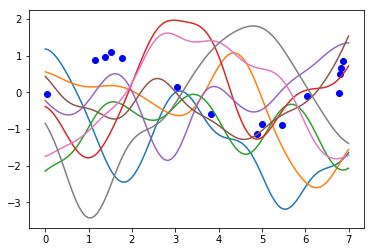

In [5]:
dim = 1

X_test = np.linspace(0, 7, 100)[:,np.newaxis]

cov_func = rbf_covariance

m = 0. # GP mean
noise_var = 0.02 # std**2
output_scale = 1
lengthscales = 0.7

kernel_params = np.array([np.sqrt(output_scale), np.sqrt(lengthscales)])

Kmm = cov_func(kernel_params, X_test)

n = 8
y_test = np.random.multivariate_normal(np.zeros(Kmm.shape[0],), Kmm, n)

for i in range(n):
    plt.plot(X_test, y_test[i,:])
plt.scatter(X, y, color='blue', label='data')
plt.show()

Стоит обратить внимание, что эта модель является _непараметрической_ (то есть не имеющей параметров) в отличие от рассмотренной ранее линейной модели:

$$f(\mathbf{x}) = \sum_{j=0}^{p-1} w_j\phi_j(\mathbf{x}) = \mathbf{w}^T\mathbf{\phi}(\mathbf{x})$$

В _параметрической_ модели функция $f(\mathbf{x})$ зависит от набора параметров $\mathbf{w}$. Сэмплируя вектора параметров из априорного распределения $\mathbf{w} \sim p(\mathbf{w})$ можно получать различные функции $f(\mathbf{x})$. В непараметрической модели на основе ГП непосредственно задается распределение над функциями $f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$.

Стоит обратить внимание, что эти модели эквивалентны, если ковариационная функция равна $k(\mathbf{x}, \mathbf{x}') = \mathbf{\phi}(\mathbf{x})^T \mathbf{\phi}(\mathbf{x}')$.


In [6]:
from scipy.linalg import solve

def predict(xstar, X, y, m, cov_params, noise_var):
    
    C = cov_func(cov_params, X) + noise_var*np.eye(X.shape[0])
    Kmm = cov_func(cov_params, xstar)
    Knm = cov_func(cov_params, X, xstar)
    
    pred_mean = np.dot(solve(C, Knm).T, y)
    pred_cov =  Kmm - np.dot(solve(C, Knm).T, Knm)  
    
    return pred_mean, pred_cov

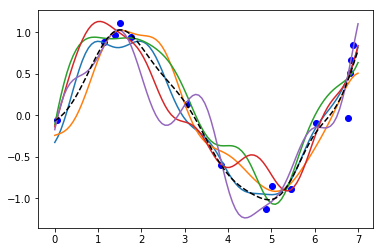

In [7]:
pred_mean, pred_cov = predict(X_test, X, y, m, kernel_params, noise_var)

n = 5
y_test = np.random.multivariate_normal(pred_mean, pred_cov, n)

for i in range(n):
    plt.plot(X_test, y_test[i,:])
plt.plot(X_test, pred_mean, 'k--')
plt.scatter(X, y, color='blue', label='data')
plt.show()

Аналогично тому, как в Байесовской линейной регрессии мы находили апостериорное распределение параметров $p(\mathbf{w}|\mathbf{y})$, здесь мы находим апостериорное распределение функций $p(\mathbf{f}|\mathbf{y})$.

[array([ 1.  ,  0.5 ,  0.05]), array([ 1.  ,  1.  ,  0.01]), array([ 1.  ,  2.  ,  0.03]), array([ 1.  ,  0.8 ,  0.01]), array([ 1. ,  1. ,  0.1]), array([ 1. ,  1.5,  0.2])]


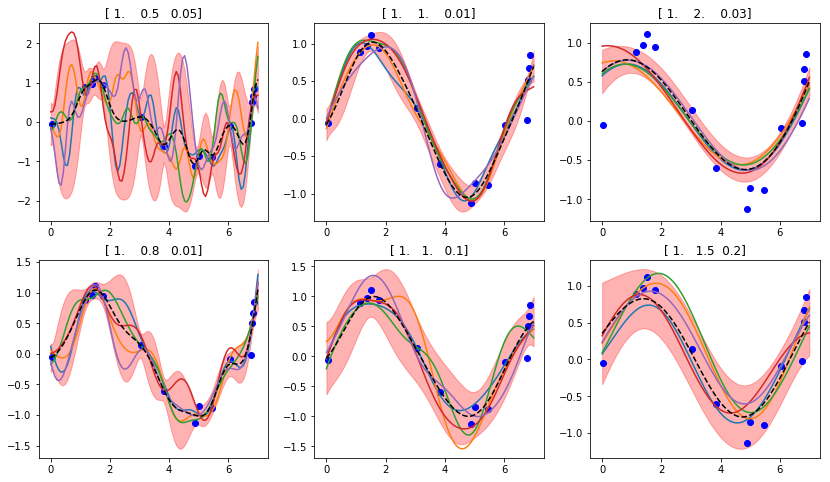

In [14]:
from itertools import product

param_list = [(1, 0.5, 0.05), (1, 1, 0.01), (1, 2, 0.03), (1, 0.8, 0.01), (1, 1, 0.1), (1, 1.5, 0.2)]

thetas = list(map(np.asarray, param_list))

print(thetas)

fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    pred_mean, pred_cov = predict(X_test, X, y, m, thetas[idx][0:2], thetas[idx][2])
    n = 5
    for i in range(n):     
        y_test = np.random.multivariate_normal(pred_mean, pred_cov)
        plt.subplot(2, 3, idx + 1)
        plt.plot(X_test, y_test)
    #plt.plot(X_test, [0] * len(X_test), '--')
    plt.plot(X_test, pred_mean, 'k--')
    std = np.sqrt(np.diag(pred_cov))
    plt.fill_between(X_test.flatten(), pred_mean-2*std, pred_mean + 2*std, color='r', alpha=0.3 )
    plt.title(str(thetas[idx]))
    plt.scatter(X, y, color='blue', label='data')

plt.show()

Мы видим, что результат сильно зависит от выбора ковариационной функции, а именно ее параметров (гиперпараметров). То есть перед нами стаит задача [выбора модели](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D0%B2%D1%8F%D0%B7%D0%B0%D0%BD%D0%BD%D1%8B%D0%B9_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4), когда модель задается значениями гиперпараметров.
Выбор гиперпараметров осуществляется путем макисмизации _маргинального правдоподобия_ (_обоснованности_): 
$$ p(\mathbf{y}) = \int p(\mathbf{y}|\mathbf{f}) p(\mathbf{f}) d\mathbf{f} $$

$$ p(\mathbf{y}) = - \frac{N}{2} \log(2\pi) - \frac{1}{2} \mathbf{y}^T \mathbf{C}^{-1} \mathbf{y} - \frac{1}{2} \log \det \mathbf{C}  $$

где $\mathbf{С} = \mathbf{K} + \sigma^{2}\mathbf{I}$.

см. http://www.gaussianprocess.org/gpml/chapters/RW5.pdf

# Classification

<img src="http://slideplayer.com/4861373/15/images/25/Gaussian+processes+for+classification+%282%29.jpg" width=600>

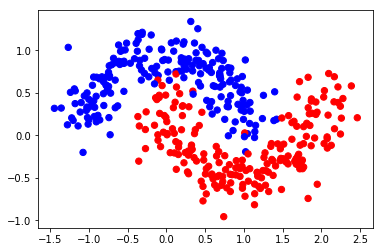

In [13]:
from sklearn.datasets import make_classification, make_moons

X, y = make_moons(400, noise=0.20)

N, dim = X.shape[0], X.shape[1]

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.bwr)
plt.show()

In [14]:
m = 0. # GP mean
noise_var = 0.01 # std**2
output_scale = 1
lengthscales = 0.7

kernel_params = np.array([np.sqrt(output_scale), np.sqrt(lengthscales)])

In [15]:
# Numerically-stable sigmoid function.
def sigmoid(x):
    mask = x>=0
    return  mask * 1/(1 + np.exp(-x * mask)) + (1-mask) * np.exp(x*(1-mask)) / (1 + np.exp(x*(1-mask)))
# Numerically-stable -log(sigmoid).
def log_loss(x):
    mask = x >=0
    return np.log(1 + np.exp(-x* mask ))*mask - (1-mask)*(x - np.log(1 + np.exp(x*(1-mask))))


В этом случае нет возможности получить аналитическое выражение для для плотности апостериорного распределения

$$p(\mathbf{f}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{f})p(\mathbf{f})}{p(\mathbf{y})} \propto p(\mathbf{y}|\mathbf{f})p(\mathbf{f}) = g(\mathbf{f})$$

Поэтому воспользуется [аппроксимацией Лапласа](http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BF%D0%BF%D1%80%D0%BE%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D1%86%D0%B8%D1%8F_%D0%9B%D0%B0%D0%BF%D0%BB%D0%B0%D1%81%D0%B0), приблизив апостериорное распределение Гауссовским:

$$ p(\mathbf{f}|\mathbf{y}) \approx N(\mathbf{f}|\mathbf{\mu}, \mathbf{\Sigma}) $$

где $\mathbf{\mu} = \mathrm{argmax}_{\mathbf{f}} \log g(\mathbf{f})$ и $\mathbf{\Sigma}^{-1} = -\nabla^2 \log g(\mathbf{f})|_{\mathbf{f} = \mathbf{\mu}}$.

Figure 1 | Figure 2
:-:|:-:
![](http://slideplayer.com/slide/4559616/15/images/31/Laplace+Approximation.jpg)  |  ![](http://images.slideplayer.com/29/9468068/slides/slide_8.jpg)

In [16]:
# Laplace approximation

from scipy.linalg import inv

def neg_log_lik_prior(f, invK, y):    
    yy = 2*y - 1    
    cost = np.sum(log_loss(yy*f)) + 0.5*np.dot(f.T, np.dot(invK, f))    
    grad = -yy*(1 - sigmoid(f)) + np.dot(invK, f)    
    return cost, grad

Knn = cov_func(kernel_params, X)
invK = inv(Knn)

In [17]:
from scipy.optimize import minimize

f_init = np.random.randn(N,)

mu = minimize(lambda f: neg_log_lik_prior(f, invK, y), f_init, method='L-BFGS-B', jac=True).x  

p = sigmoid(mu)
invW = np.diag(1/(p*(1 - p)))

В этом случае нет возможности получить распределение для прогноза аналитически. Поэтому приблизим его с помощью [метода Монте-Карло](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9C%D0%BE%D0%BD%D1%82%D0%B5-%D0%9A%D0%B0%D1%80%D0%BB%D0%BE):

$$p(\mathbf{y}_*|\mathbf{y}) = \mathbb{E}_{p(\mathbf{f}_{*}|\mathbf{y})}[p(\mathbf{y}_*|\mathbf{f}_*)] \approx \frac{1}{T}\sum_t p(\mathbf{y}_*|\mathbf{f}_{*t})$$

где $\mathbf{f}_{*t}$ генерируются из распределения $p(\mathbf{f}_{*}|\mathbf{y})$.

In [18]:
def predict_class(xstar, mu, invW, m, cov_params, noise_var):
    
    C = cov_func(cov_params, X) + invW
    Kmm = cov_func(cov_params, xstar)
    Knm = cov_func(cov_params, X, xstar)

    pred_mean = m + np.dot(solve(C, Knm).T, mu - m)
    pred_cov = Kmm - np.dot(solve(C, Knm).T, Knm)
      
    n = 100
    f = np.random.multivariate_normal(pred_mean, pred_cov, n)
    
    probs = np.mean(sigmoid(f), axis=0)
    
    return probs, f[0:20,:]
    

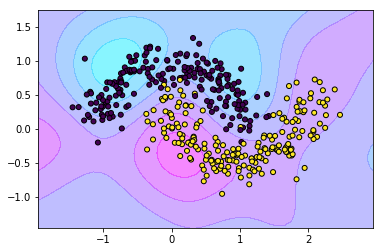

In [19]:
h = .1  # step size in the mesh

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]

probs, ff = predict_class(X_test, mu, invW, m, kernel_params, noise_var)

Z = probs.reshape(xx.shape)# > 0.5

plt.contourf(xx, yy, Z, cmap=plt.cm.cool, alpha=.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

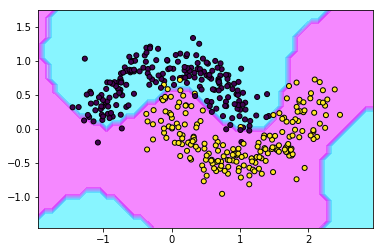

In [20]:
plt.contourf(xx, yy, Z>0.5, cmap=plt.cm.cool, alpha=.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

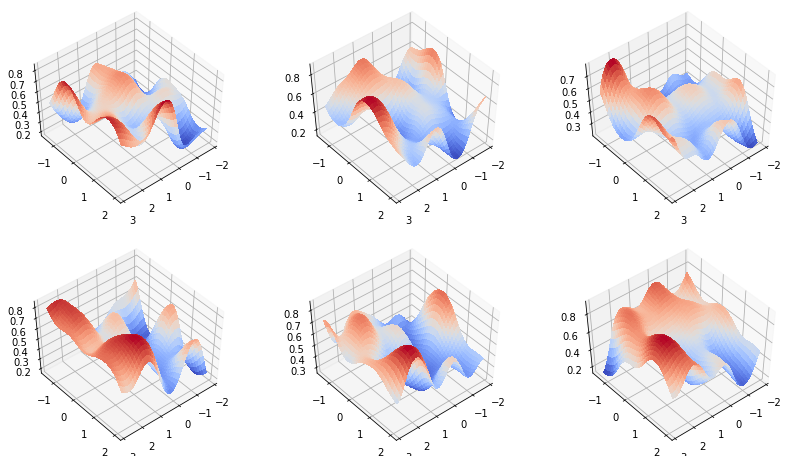

In [97]:
fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    ax = plt.subplot(2, 3, idx + 1, projection='3d')   
    ax.plot_surface(xx, yy, sigmoid(ff[idx,:]).reshape(xx.shape), cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(elev=50., azim=50)
plt.show()

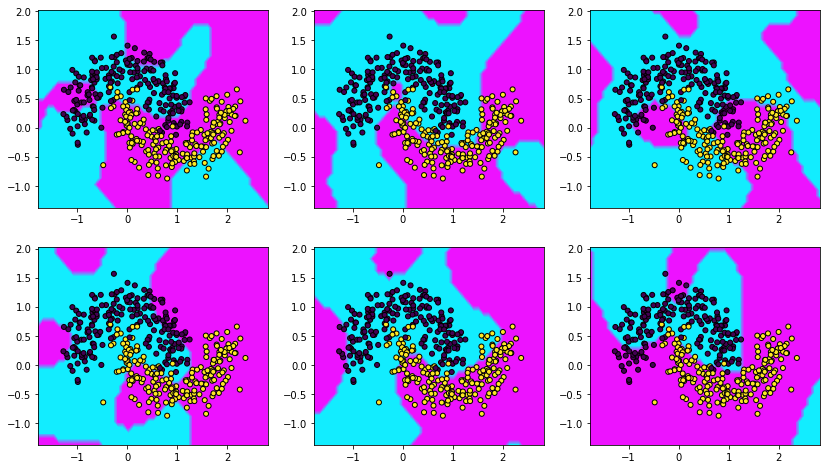

In [100]:
fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    ax = plt.subplot(2, 3, idx + 1)   
    ax.contourf(xx, yy, sigmoid(ff[idx,:]).reshape(xx.shape)>0.5, cmap=plt.cm.cool, linewidth=0, antialiased=False)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

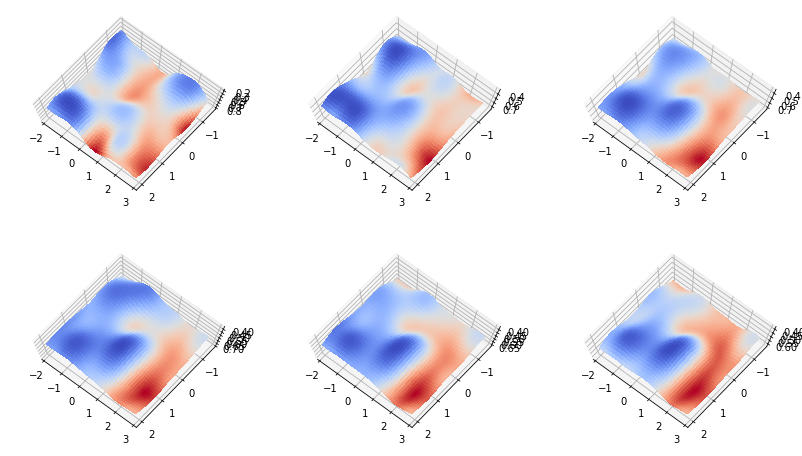

In [98]:
fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    ax = plt.subplot(2, 3, idx + 1, projection='3d')   
    ax.plot_surface(xx, yy, np.mean(sigmoid(ff[0:3*idx+1,:]), axis=0).reshape(xx.shape), cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(elev=10000., azim=50)
plt.show()

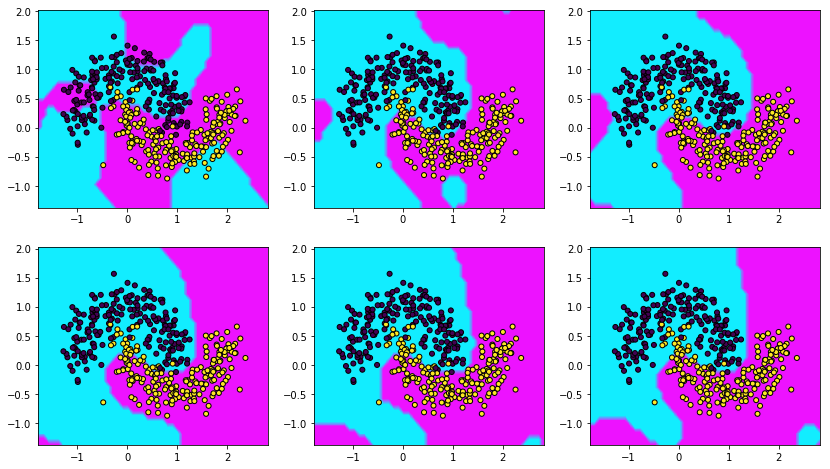

In [102]:
fig = plt.figure()
fig.set_size_inches(14, 8)
for row, col in product(range(2), range(3)):
    idx = row * 3 + col
    ax = plt.subplot(2, 3, idx + 1)   
    ax.contourf(xx, yy, np.mean(sigmoid(ff[0:3*idx+1,:]), axis=0).reshape(xx.shape)>0.5, cmap=plt.cm.cool, linewidth=0, antialiased=False)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()